In [1]:
import os
import time
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.transforms as mt
from sklearn.neighbors import KDTree
import pandas as pd

def grid_x(r_num, c_num, num_per_clu=10, noise=0.02):
    c_true = r_num * c_num
    N = num_per_clu * c_true

    Cen = np.meshgrid(np.arange(r_num), np.arange(c_num))
    Cen2 = np.stack(Cen, -1)
    Cen3 = Cen2.reshape(-1, 2)

    Cen4 = np.repeat(Cen3, repeats=num_per_clu, axis=0)

    mean = [0, 0]
    cov = np.eye(2) * noise
    tur_data = np.random.multivariate_normal(mean, cov, size=N)

    X = Cen4 + tur_data
    y = np.repeat(np.arange(c_true), repeats=num_per_clu)

    return X, y

def kdtree(X, knn):
    t1 = time.time()
    tree = KDTree(X, leaf_size=40)
    NND, NN = tree.query(X, k=knn)
    t2 = time.time()
    return NN, NND, t2 - t1

def save(X, y, NN, NND, knn, t, name):
    sio.savemat(name, {"X": X, "y_true": y, "NND": NND, "NN": NN, "knn": knn, "knn_time": t})

def gen_grid(rc, num, knn):
    r_num = rc[0]
    c_num = rc[1]

    c_true = int(r_num*c_num)

    num_per_clu = int(num/c_true)

    print(int(num/1000), num_per_clu, int(c_true/1000))
    X, y = grid_x(r_num, c_num, num_per_clu=num_per_clu, noise=0.03)

    NN, NND, t = kdtree(X, knn)
    return X, y, NN, NND, t

def relabel(y, offset=0):
    y_df = pd.DataFrame(data=y, columns=["label"])
    ind_dict = y_df.groupby("label").indices

    for yi, ind in ind_dict.items():
        y[ind] = offset
        offset += 1
    return y

In [2]:
## generation

current_path = os.path.dirname("G:\HKU\COMP7404 Computational intelligence and machine learning\group")
data_path = os.path.join(current_path, "data")

num = 100000
rc = [50, 100]

c_true = int(rc[0] * rc[1])
knn = int(num / c_true * 1.2)

gen_X, y, NN, NND, t = gen_grid(rc, num, knn)
print(gen_X.shape)
print(y.shape)

100 20 5
(100000, 2)
(100000,)


(100000, 2)
(100000,)


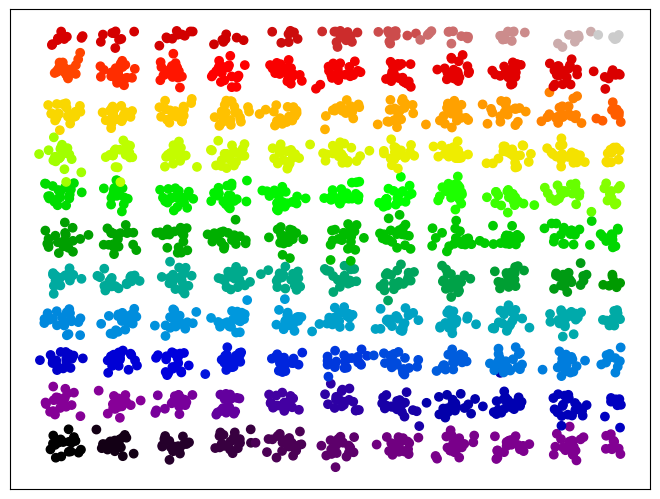

In [21]:
# plot D1
X_plot, y_plot = gen_X, y.reshape(-1)
print(X_plot.shape)
print(y_true.shape)
ind = np.logical_and(X_plot[:, 0] < 10, X_plot[:, 1] < 10)
X_plot= X_plot[ind]
y_plot = y_true[ind]
plt.figure(figsize=(6.4, 4.8))
y_plot = relabel(y_plot)
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, cmap="nipy_spectral")
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0.05, 0.05)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.show()
# full_name = os.path.join(data_path, "D1.png")
# plt.savefig(full_name, dpi = 300, bbox_inches=mt.Bbox([[-0.1, -0.1], [6.5, 4.9]]))

In [15]:
from ksums import KSUMS

X, y_true, c_true, NN, NND, t1 = gen_X, y, len(np.unique(y)), NN, NND, t
print(X.shape)
print(y_true.shape)

(100000, 2)
(100000,)


In [16]:
obj = KSUMS(NN.astype(np.int32), NND, c_true, debug=True, max_dd=-1)
obj.opt(rep=3, MAX_ITER=100, our_init=1)
t2 = obj.time_arr

max_distance is 1.0350673974468214
sample number = 100000, with 5000 clusters
NN is ndarray? True
NND is ndarray? True
symmetry add 181990 times
num_clu = 5118 (c = 5000)
num_clu = 5118 (c = 5000)
num_clu = 5118 (c = 5000)


In [17]:
print(obj.Y.shape)
print(y_true.shape)

(3, 100000)
(100000,)


In [18]:
import evaluation
acc = evaluation.multi_accuracy(y_true, obj.Y)
nmi = evaluation.multi_nmi(y_true, obj.Y)
ari = evaluation.multi_ari(y_true, obj.Y)
print(f"generated_grid: {np.mean(acc):.3f}(±{np.std(acc):.2e}), {np.mean(nmi):.3f}(±{np.std(nmi):.2e}), {np.mean(ari):.3f}(±{np.std(ari):.2e}), {t1 + np.mean(t2):.3f}(±{t1 + np.std(t2):.2e})")
 

generated_grid: 0.937(±2.44e-03), 0.986(±3.99e-04), 0.924(±2.26e-03), 48.448(±5.78e+00)


In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment  # 使用Scipy的linear_sum_assignment

def compute_f1(y_true, y_pred):
    # confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    n_true = cm.shape[0]
    n_pred = cm.shape[1]
    
    cost = np.max(cm) - cm
    row_ind, col_ind = linear_sum_assignment(cost)
    
    pred_to_true = {pred_idx: true_idx for true_idx, pred_idx in zip(row_ind, col_ind)}
    y_pred_aligned = np.array([pred_to_true[pred] for pred in y_pred])
    
    tp = np.zeros(n_true)
    fp = np.zeros(n_true)
    fn = np.zeros(n_true)
    
    for true_class in range(n_true):
        true_mask = (y_true == true_class)
        pred_mask = (y_pred_aligned == true_class)
        
        tp[true_class] = np.sum(true_mask & pred_mask)
        fp[true_class] = np.sum(~true_mask & pred_mask)
        fn[true_class] = np.sum(true_mask & ~pred_mask)
    
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    f1_per_class = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # F1
    macro_f1 = np.mean(f1_per_class)
    return macro_f1

def multi_F1(y_true, Y_predict):
    ret = np.array([compute_f1(y_true=y_true, y_pred=y_pred) for y_pred in Y_predict])
    return ret

In [20]:
f1 = multi_F1(y_true, obj.Y)
print(f"{np.mean(f1):.3f}")

0.920
